# Displacement Between cluster groups

Instead of finding the displacement of individual clusters, we now make it such that the distance between vertexes is detected instead

In [11]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
from cellpose import models, io
from cellpose.io import imread
from pathlib import Path
import os
from Modules import specificOutline, getFileDir, getOutlines, smoother, splitImg, plotSide # Custom module for readability
import Modules_Displacement # custom module for readability
import Modules
from PIL import Image

# List of Files
# Importing all the files

# the folder containing the .npy and png (or .tif files) are stored 
npyDir = "Haltere" # CHANGE THIS
cellTypeName = npyDir
cellTypePlot = cellTypeName + "Plots"
numOfClusters = 8 # 8 for haltere, 15 for wing for the two files I set

# Makes the directy to point to the seg files
basedir = os.path.join(Path.cwd(), npyDir)
files = io.get_image_files(basedir, "")
dir = []
for f in files: 
    dir.append((os.path.join(basedir, f) + "_seg.npy").replace(".tif", ""))
dir = dir

In [12]:
roi_name = [] # a list containing the name of the roi we need

for i in range(len(dir)):  
    dat = np.load(dir[i], allow_pickle=True).item()
    masks = dat['masks'] # Using the masks gives us a larger target to select from than outlines
    filenam = dat['filename']
    width, height = masks.shape
    neededROI = masks[width//2][height//2] # the general area of where our ROI will always be
    # the below code saves the outline in an image file
    if neededROI != 0: 
        roi_name.append([i, neededROI])

# Method
The thought process for this method is that the cell we want will be boreder by other cells. However, the vertexes of those cells will be bordered by 3 cells. The cell we want, and two other cells. 

The "outlines" part of the .npy files contains the outlines for a particular cell. By iterating through this 2D array, we can obtain the coordinates for the border of the cell we are interested in. Now for each of these coordinates, we can create a 3 x 3 sized 2D matrix subarray where the coordinate we input is the center. This will give us the coordinates for the vertexes


In [13]:
# function to find the vertexes. 
# works by looking at the items surround i, j 
# filters out so only the unique items are found
# if it is bordered by more than 3 unique items, then it is a vertex point
# Check 
def findVertex(masks, j, i, k = 2):  
    surr =[masks.item((j+k, i-k)),
    masks.item((j+k, i)),
    masks.item((j+k, i+k)),
    masks.item((j, i-k)),
    masks.item((j, i)),
    masks.item((j, i+k)),
    masks.item((j-k, i-k)),
    masks.item((j-k, i)),
    masks.item((j-k, i+k))]
    # the set() function returns the unique values of the array. If the size of the list is more than
    # 2, then we can return j, i. As this means that it is bordered by at least 3 cells
    if len(list(set(surr)))>2: 
        return [j, i]

def dist(f, g): # displacement 
    return np.sqrt((f[0] - g[0])**2 + (f[1] - g[1])**2)

def dist2(ListOfSpecificVertex, i): 
    return np.sqrt[dist(ListOfSpecificVertex[0], ListOfSpecificVertex[i])] # Gets you the T0 - T(n)    

What we can do now, is repeat the above function for two different points, and see what happens for the one above and below 

In [118]:
M = [] # list containing all the masks
O = [] # list containing all the outlines

for k in range(len(roi_name)): 
    # Get the file number, and the roi of the cell we are interested in
    num, roi = roi_name[k]
    dat = np.load(dir[num], allow_pickle=True).item()
    masks = dat['masks']
    outlines = dat['outlines']

    # Get the masks and the outlines of the cell we are interested in
    # M.append(specificOutline(masks, roi)) # list containing all the masks
    M.append(masks)
    O.append(specificOutline(outlines, roi)) # list containing all the outlines
    
pointsList = []

for k in range(len(M)): 
    points = []
    o = O[k]
    height, width = o.shape
    # iterate through the matrix and get the coordinates that make up the outline
    # of the cell we are interested in
    for i in range(height): 
        for j in range(width): 
            if o[i][j] != 0: 
                points.append([j, i])
    # points is now a list which contains the coordinates for each point that matters for our outline
    # store the vertexes for file number k in the array
    pointsList.append(points)

# plt.imshow(O[5])
# plt.imshow(M[5])

In [119]:
mainVertexList = []
for q in range(len(roi_name)): 
    points = pointsList[q] # specific set of points

    X = np.array(pointsList[q])[:, 0]
    Y = np.array(pointsList[q])[:, 1]

    vertexes = []
    for k in range(len(points)): 
        i, j = points[k]
        vert = findVertex(masks, j, i) # This finds if a particular point is a vertex or not
        if vert: 
            vertexes.append(vert)
    mainVertexList.append(vertexes) # a list of the vertexes


In [18]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy
from sklearn.cluster import KMeans
import pandas as pd

count = 0 
for i in mainVertexList:  
    count += 1
    if len(i) < 2: 
        mainVertexList.pop(count)

# change num of clusters manually 

kmeans = KMeans(n_clusters= numOfClusters, random_state=42) 
a = []
x = []
for i in range(len(mainVertexList)): 
    X = mainVertexList[i]
    if len(X) > 1: 
        clusts = kmeans.fit_predict(X)
        df = pd.DataFrame(X)
        df["labels"] = clusts
        df["frame"] = i 
        x.append(df)

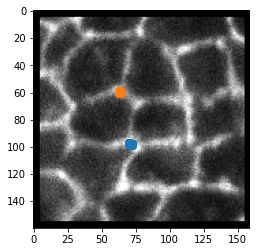

In [102]:
# # I need to relabel the clusters so that it looks nice enough hahahaha
allx = pd.concat(x)
# plt.scatter(allx[1], allx[0])
C = list(zip(allx[1], allx[0]))
clusts = kmeans.fit_predict(C)

allx["clusterNum"] = clusts

clus1 = allx.loc[allx["clusterNum"] == 3] # select the cluster you want to look at
clus2 = allx.loc[allx["clusterNum"] == 6] # select the cluster you want to look at 
f, ax = plt.subplots()
ax.scatter(clus1[1], clus1[0])
ax.scatter(clus2[1], clus2[0])
df = pd.DataFrame(X)
plt.imshow(Image.open(files[0]))

In [91]:
displacement = []
X1, X2, Y1, Y2 = ([] for i in range(4))
fnum = []

for k in range(max(max(clus1["frame"]), max(clus2["frame"]))):

    a = clus1.loc[clus1["frame"] == k]
    b = clus2.loc[clus2["frame"] == k]
    if len(a) > 0 and len(b) > 0: 
        fnum.append(k)
        X1.append(a.mean()[0])
        Y1.append(a.mean()[1])
        X2.append(b.mean()[0])
        Y2.append(b.mean()[1])

        
X1 = np.array(X1)
X2 = np.array(X2)
Y1 = np.array(Y1)
Y2 = np.array(Y2)

displacement = np.sqrt((Y2 - Y1)**2 + (X2- X1)**2)


In [99]:
import scipy.optimize

stepsize = (0.823 - 0.549)/2
tempX = np.arange(0.549, stepsize * (len(displacement) + 1), stepsize).tolist()
bigX = [ 0.549/3 * i for i in range(3)]
bigX = bigX + tempX
len(bigX)


def expon(t, a, b, c): 
    return a*t**b + c
    
A = scipy.optimize.curve_fit(expon,  bigX,  displacement)
a, b, c = A[0]
nY = []
for i in bigX:
    nY.append(expon(i, a, b, c))

C:\Users\birat\AppData\Local\Temp\ipykernel_10364\1889247433.py:11: RuntimeWarning: divide by zero encountered in power
  return a*t**b + c


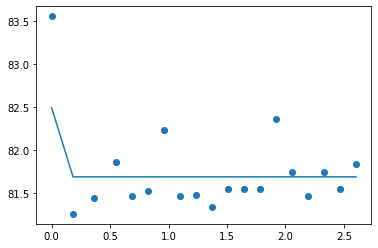

In [100]:
plt.scatter(bigX, displacement)
plt.plot(bigX, nY)